In [1]:
import sys
import glob
import re
import h5py

import numpy as np

import datetime

import matplotlib.pyplot as plt

# Need IS2_calval repository (https://github.com/SmithB/IS2_calval),
# which contains python modules required by read_xovers. Append the path
# of that repository to sys.path so that Python can find it.
sys.path.append('/att/gpfsfs/home/dfelikso/Software/ICESat-2/IS2_calval')
from read_xovers import read_xovers


# Read in the crossovers

Here's where we can specify which crossovers to read by using a wildcard to search for particular files, specifying min/max delta t, or specifying spatial bounds in polar sterographic coordinates. See read_xovers.py for more information on options for how to read in files.

The read_xovers function returns 4 variables:
1. **v**: dict of nx2 matrices, giving ATL06 parameters interpolated to the crossover locations.  The first column gives the value for the first measurement in the crossover, the second the value from the second.
1. **delta**: dict of nx1 matrices, giving ATL06 parameter differences between the crossover measurents, late minus early
1. **bar**: dict of nx1 matrices, giving ATL06 parameter averages between the crossover measurents
1. **meta**: metadata values at the crossovers


In [5]:
# Specify the directory where crossovers are located
xover_dir = '/att/nobackup/dfelikso/ATL06_xo/Arctic/r005/c10'

#-176576,-2278847

v, delta, bar, meta = read_xovers(xover_dir, wildcard='E-200000_N-2200000', \
                                  delta_t_min=0, delta_t_max=np.inf, verbose=True)
meta['slope_mag']=np.abs(meta['slope_x']+1j*meta['slope_y'])


Found 294 crossover tiles
Reading 1 crossover tiles
Tiles contain 238 crossovers


# Find all crossovers within bounding box and plot statistics

Text(0, 0.5, 'probability')

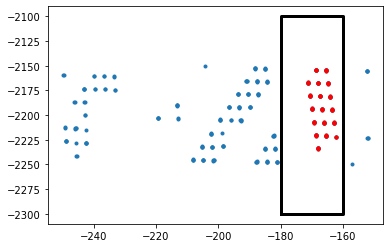

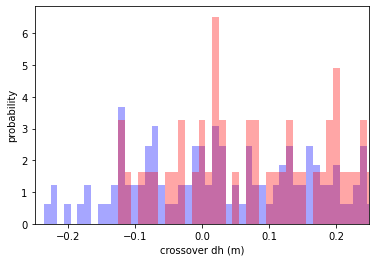

In [7]:
# Specify x/y bounds
x_min = -180000
x_max = -160000
y_min = -2300000
y_max = -2100000

# Select the crossovers
idx = np.logical_and( \
               np.logical_and( bar['x'] > x_min, bar['x'] < x_max ), \
               np.logical_and( bar['y'] > y_min, bar['y'] < y_max ) )

# Map
fig, ax = plt.subplots(1,1)
ax.plot(bar['x']/1000., bar['y']/1000., '.')
ax.plot(np.array([x_min, x_min, x_max, x_max, x_min])/1000., np.array([y_min, y_max, y_max, y_min, y_min])/1000., 'k-', linewidth=3)
ax.plot(bar['x'][idx]/1000., bar['y'][idx]/1000., 'r.')

# Histogram
bins = np.linspace(-1, 1, 200)

fig, ax = plt.subplots(1,1)
ax.hist(delta['h_li'], bins=bins, density=True, fc=(0, 0, 1, 0.35))
ax.hist(delta['h_li'][idx], bins=bins, density=True, fc=(1, 0, 0, 0.35))
ax.set_xlim(-0.25, +0.25)
ax.set_xlabel('crossover dh (m)')
ax.set_ylabel('probability')


# Scatter plot of all crossovers according to delta t

Minimum crossover delta t:   3.46 days
Maximum crossover delta t:  65.34 days


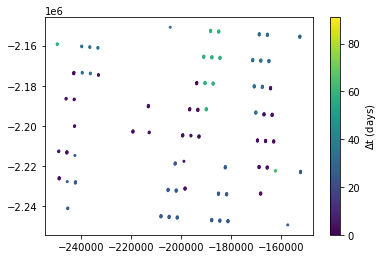

In [12]:
# Map of delta t's to see the spatial pattern of delta t's
plt.scatter(bar['x'], bar['y'], s=4, c=delta['delta_time']/86400., vmin=0, vmax=91)
plt.colorbar(label='$\Delta$t (days)')

print('Minimum crossover delta t: {:6.2f} days'.format(np.min(delta['delta_time']/86400)))
print('Maximum crossover delta t: {:6.2f} days'.format(np.max(delta['delta_time']/86400)))


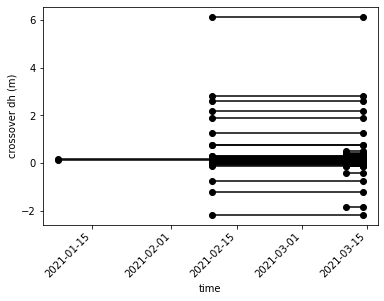

In [13]:
# Convert ATL06 times per track (stored in 'v') into UTC
# NOTE: This neglects leap seconds and the following code will convert times to UTC but will be missing 
# any leap seconds that have been issued since 01/01/2018. Nevertheless, it's fine for our purposes.
atlas_epoch = datetime.datetime(2018,1,1,0,0,0)

xover_time_utc = list()
xover_dh = list()
for i in np.where(idx)[0]:
    t = [atlas_epoch + datetime.timedelta(seconds=s) for s in v['delta_time'][i]]
    xover_time_utc.append(t)
    xover_dh.append(delta['h_li'][i])

# Plot
for i in range(len(xover_time_utc)):
    plt.plot([xover_time_utc[i][0], xover_time_utc[i][1]], [xover_dh[i], xover_dh[i]], 'ko-')

plt.xlabel('time')
plt.ylabel('crossover dh (m)')
_ = plt.xticks(rotation=45, ha='right')
